# Project 3
## Problem 2 - Using Tensorflow - Ising Model

Next, we show how one can use deep neural nets to classify the states of the 2D Ising model according to their phase. This should be compared with the use of logistic-regression in earlier HW.

The Hamiltonian for the classical Ising model is given by

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. Onsager proved that this model undergoes a phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.

### Step 1: Load and Process the Data

We begin by writing a `DataSet` class and two functions `read_data_sets` and `load_data` to process the 2D Ising data.

The `DataSet` class performs checks on the data shape and casts the data into the correct data type for the calculation. It contains a function method called `next_batch` which shuffles the data and returns a mini-batch of a pre-defined size. This structure is particularly useful for the training procedure in TensorFlow.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !pip install tensorflow
!pip install tensorflow~=2.10.0
!pip install scikit-learn

In [5]:
# -*- coding: utf-8 -*-
import numpy as np
from scipy.integrate import quad
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

seed=12
np.random.seed(seed)
import sys, os, argparse
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.framework import dtypes
tf.compat.v1.disable_eager_execution()

# suppress tflow compilation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.set_random_seed(seed)

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
# Decorations :D
def canvas_ticks(obj):
    '''This provides ticks in to a blanck canvas, for singular plots
    use plt as the argumenet, for suplots, in for gridspec for expample
    insert ax1 as argument'''
    obj.minorticks_on()
    obj.tick_params(labelsize=14)
    obj.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    obj.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
    obj.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)

plt.style.use('default')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
error_bar_settings = {
        'fmt': 'o',
        'ms': 7,
        # 'mfc': plot_color,
        'ecolor': 'black',
        'mec': 'black',
        'capsize': 2,
        'mew': 0.5,
        'elinewidth': .5,
        # 'alpha': 0.85,
    }
%config InlineBackend.figure_format = 'retina'


In [7]:
class DataSet(object):

    def __init__(self,data_X,data_Y,dtype=dtypes.float32):
        """Checks data and casts it into correct data type. """

        dtype = dtypes.as_dtype(dtype).base_dtype
        if dtype not in (dtypes.uint8, dtypes.float32):
            raise TypeError('Invalid dtype %r, expected uint8 or float32' % dtype)

        assert data_X.shape[0] == data_Y.shape[0], ('data_X.shape: %s data_Y.shape: %s' % (data_X.shape, data_Y.shape))
        self.num_examples = data_X.shape[0]

        if dtype == dtypes.float32:
            data_X = data_X.astype(np.float32)
        self.data_X = data_X
        self.data_Y = data_Y

        self.epochs_completed = 0
        self.index_in_epoch = 0

    def next_batch(self, batch_size, seed=None):
        """Return the next `batch_size` examples from this data set."""

        if seed:
            np.random.seed(seed)

        start = self.index_in_epoch
        self.index_in_epoch += batch_size
        if self.index_in_epoch > self.num_examples:
            # Finished epoch
            self.epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self.num_examples)
            np.random.shuffle(perm)
            self.data_X = self.data_X[perm]
            self.data_Y = self.data_Y[perm]
            # Start next epoch
            start = 0
            self.index_in_epoch = batch_size
            assert batch_size <= self.num_examples
        end = self.index_in_epoch

        return self.data_X[start:end], self.data_Y[start:end]

Now, load the Ising dataset, and splits it into three subsets: ordered, critical and disordered, depending on the temperature which sets the distribution they are drawn from. Once again, we use the ordered and disordered data to create a training and a test data set for the problem. Classifying the states in the critical region is expected to be harder and we only use this data to test the performance of our model in the end.

In [8]:

import pickle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import collections

L=40 # linear system size

# load data
fac = 25
file_name = "/content/drive/My Drive/P188_288/P188_288_Project3/Ising2DFM_reSample_L40_T=All.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
data = pickle.load(open(file_name,'rb')) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = data[::fac]
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

file_name = "/content/drive/My Drive/P188_288/P188_288_Project3/Ising2DFM_reSample_L40_T=All_labels.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
labels = pickle.load(open(file_name,'rb')) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

# divide data into ordered, critical and disordered
X_ordered=data[:int(70000/fac),:]
Y_ordered=labels[:70000][::fac]

X_critical=data[int(70000/fac):int(100000/fac),:]
Y_critical=labels[70000:100000][::fac]

X_disordered=data[int(100000/fac):,:]
Y_disordered=labels[100000:][::fac]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered)) #np.concatenate((X_ordered,X_critical,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered)) #np.concatenate((Y_ordered,Y_critical,Y_disordered))

del X_ordered, X_disordered, Y_ordered, Y_disordered


In [9]:
# pick random data points from ordered and disordered states to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.6)


# make data categorical
Y_train=to_categorical(Y_train)
Y_test=to_categorical(Y_test)
Y_critical=to_categorical(Y_critical)


# create data sets
train = DataSet(X_train, Y_train, dtype=dtypes.float32)
test = DataSet(X_test, Y_test, dtype=dtypes.float32)
critical = DataSet(X_critical, Y_critical, dtype=dtypes.float32)

Datasets = collections.namedtuple('Datasets', ['train', 'test', 'critical'])
Dataset = Datasets(train=train, test=test, critical=critical)

You can load the training data in the following way: (Dataset.train.data_X, Dataset.train.data_Y).

### Steps 2+3: Define the Neural Net and its Architecture, Choose the Optimizer and the Cost Function

We can now move on to construct our deep neural net using TensorFlow.

Unique for TensorFlow is creating placeholders for the variables of the model, such as the feed-in data `X` and `Y` or the dropout probability `dropout_keepprob` (which has to be set to unity explicitly during testing). Another peculiarity is using the `with` scope to give names to the most important operators. While we do not discuss this here, TensorFlow also allows one to visualise the computational graph for the model (see package documentation on [https://www.tensorflow.org/](https://www.tensorflow.org/)).

The shape of X is only partially defined. We know that it will be a matrix, with instances along the first dimension and features along the second dimension, and we know that the number of features is going to be $28\times28$, but we don't know yet how many instances each training batch will contain. So the shape of X is (None, n_inputs). Similarly, we know that Y will be a vector with one entry per instance, but again we don't know the size of the training batch, so the shape is (None).

In [10]:
L=40 # system linear size
n_feats=L**2 # 40x40 square lattice
n_categories=2 # 2 Ising phases: ordered and disordered

n_hidden1 = 300
n_hidden2 = 100
n_outputs = 2

with tf.name_scope('data'):
    X=tf.compat.v1.placeholder(tf.float32, shape=(None,n_feats))
    Y=tf.compat.v1.placeholder(tf.float32, shape=(None,n_categories))
    dropout_keepprob=tf.compat.v1.placeholder(tf.float32)


To classify whether a given spin configuration is in the ordered or disordered phase, we construct a minimalistic model for a DNN with a single hidden layer containing $N_\mathrm{neurons}$ (which is kept variable so we can try out the performance of different sizes for the hidden layer).

Let us use a neuron_layer() function to create layers in the neural nets.

1. First, create a name scope using the name of the layer.
2. Get the number of inputs by looking up the input matrix's shape and getting the size of the second dimension.
3. Create a $W$ variable which holds the weight matrix (i.e. kernel).  Initialize it randomly, using a truncated normal distribution.
4. Create a $b$ variable for biases, initialized to 0.
5. Create a subgraph to compute $Z=XW+b$
6. Use activation function if provided.

In [11]:
def neuron_layer(X, n_neuron, name, activation = None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_neuron)
        init = tf.truncated_normal((n_inputs, n_neuron), stddev = stddev)
        W = tf.Variable(init, name = "kernel")
        b = tf.Variable(tf.zeros([n_neuron]), name = "bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

Using a neuron_layer() function, create two hidden layers and an output layer. The first hidden layer takes X as its input, and the second takes the output of the first hidden layer as its input. Finally, the output layer takes the output of the second hidden layer as its input.


In [12]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs)

Then, define the cost function that we will use to train the neural net model. Here, use the cross entropy to penalize models that estimate a low probability for the target class.

In [13]:
with tf.name_scope('loss'):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = logits)
    loss = tf.reduce_mean(xentropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Then, define a GradientDescentOptimizer that will tweak the model parameters to minimize the cost function. Now, set learning_rate = 1e-6.

In [14]:
learning_rate = 1e-6
with tf.name_scope('optimiser'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)


Lastly, specify how to evaluate the model. Let us simply use accuracy as our performance measure.

In [15]:

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float64) # change data type
#     correct_prediction = tf.nn.in_top_k(logits, Y, 1)
    accuracy = tf.reduce_mean(correct_prediction)


### Steps 4+5: Train the Model and Evaluate its Performance

We train our DNN using mini-batches of size $100$ over a total of $100$ epochs, which we define first. We then set up the optimizer parameter dictionary `opt_params`, and use it to create a DNN model.

Running TensorFlow requires opening up a `Session` which we abbreviate as `sess` for short. All operations are performed in this session by calling the `run` method. First, we initialize the global variables in TensorFlow's computational graph by running the `global_variables_initializer`. To train the DNN, we loop over the number of epochs. In each fix epoch, we use the `next_batch` function of the `DataSet` class we defined above to create a mini-batch. The forward and backward passes through the weights are performed by running the `loss` and `optimizer` methods. To pass the mini-batch as well as any other external parameters, we use the `feed_dict` dictionary. Similarly, we evaluate the model performance, by getting `accuracy` on the same minibatch data. Note that the dropout probability for testing is set to unity.

Once we have exhausted all training epochs, we test the final performance on the entire training, test and critical data sets. This is done in the same way as above.

Last, we return the loss and accuracy for each of the training, test and critical data sets.

In [16]:
training_epochs=100
batch_size=100

with tf.Session() as sess:

    # initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer())

    # train the DNN
    for epoch in range(training_epochs):

        batch_X, batch_Y = Dataset.train.next_batch(batch_size)

        sess.run(optimizer, feed_dict={X: batch_X,Y: batch_Y,dropout_keepprob: 0.5})


    # test DNN performance on entire train test and critical data sets
    train_loss, train_accuracy = sess.run([loss, accuracy],
                                                feed_dict={X: Dataset.train.data_X,
                                                           Y: Dataset.train.data_Y,
                                                           dropout_keepprob: 0.5}
                                                            )
    print("train loss/accuracy:", train_loss, train_accuracy)

    test_loss, test_accuracy = sess.run([loss, accuracy],
                                                feed_dict={X: Dataset.test.data_X,
                                                           Y: Dataset.test.data_Y,
                                                           dropout_keepprob: 1.0}
                                                           )

    print("test loss/accuracy:", test_loss, test_accuracy)

    critical_loss, critical_accuracy = sess.run([loss, accuracy],
                                                feed_dict={X: Dataset.critical.data_X,
                                                           Y: Dataset.critical.data_Y,
                                                           dropout_keepprob: 1.0}
                                                           )
    print("crtitical loss/accuracy:", critical_loss, critical_accuracy)



train loss/accuracy: 1.1138343 0.5330128205128205
test loss/accuracy: 1.1416363 0.5211538461538462
crtitical loss/accuracy: 0.8643694 0.6466666666666666


### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

To study the dependence of our DNN on some of the hyperparameters, we do a grid search over the number of neurons (initially set as 100) in the hidden layer, and different SGD learning rates (initially set as 1e-6). These searches are best done over logarithmically-spaced points.

To do this, define a function for creating a DNN model: `create_DNN` and for evaluating the performance: `evaluate_model`.

The function `grid_search` will output 2D heat map to show how accuracy changes with learning rate and number of neurons.

In [17]:
def create_DNN(n_hidden1=100, n_hidden2=100, learning_rate=1e-6):
    with tf.name_scope('data'):
        X=tf.placeholder(tf.float32, shape=(None,n_feats))
        Y=tf.placeholder(tf.float32, shape=(None,n_categories))
        dropout_keepprob=tf.placeholder(tf.float32)

    with tf.name_scope("dnn"):
        hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu)
        logits = tf.layers.dense(hidden2, n_outputs)

    with tf.name_scope('loss'):
        xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = logits)
        loss = tf.reduce_mean(xentropy)

    with tf.name_scope('optimiser'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float64) # change data type
    #     correct_prediction = tf.nn.in_top_k(logits, Y, 1)
        accuracy = tf.reduce_mean(correct_prediction)

    return X, Y, dropout_keepprob, loss, optimizer, accuracy


In [18]:
def evaluate_model(neurons,lr):

    training_epochs=100
    batch_size=100


    X, Y, dropout_keepprob, loss, optimizer, accuracy = create_DNN(n_hidden1=neurons, n_hidden2=neurons, learning_rate=lr)
    with tf.Session() as sess:

        # initialize the necessary variables, in this case, w and b
        sess.run(tf.global_variables_initializer())

        # train the DNN
        for epoch in range(training_epochs):

            batch_X, batch_Y = Dataset.train.next_batch(batch_size)

            sess.run(optimizer, feed_dict={X: batch_X,Y: batch_Y,dropout_keepprob: 0.5})


        # test DNN performance on entire train test and critical data sets
        train_loss, train_accuracy = sess.run([loss, accuracy],
                                                    feed_dict={X: Dataset.train.data_X,
                                                               Y: Dataset.train.data_Y,
                                                               dropout_keepprob: 0.5}
                                                                )
        print("train loss/accuracy:", train_loss, train_accuracy)

        test_loss, test_accuracy = sess.run([loss, accuracy],
                                                    feed_dict={X: Dataset.test.data_X,
                                                               Y: Dataset.test.data_Y,
                                                               dropout_keepprob: 1.0}
                                                               )

        print("test loss/accuracy:", test_loss, test_accuracy)

        critical_loss, critical_accuracy = sess.run([loss, accuracy],
                                                    feed_dict={X: Dataset.critical.data_X,
                                                               Y: Dataset.critical.data_Y,
                                                               dropout_keepprob: 1.0}
                                                               )
        print("crtitical loss/accuracy:", critical_loss, critical_accuracy)

    return train_loss,train_accuracy,test_loss,test_accuracy,critical_loss,critical_accuracy

In [19]:
def grid_search():
    """This function performs a grid search over a set of different learning rates
    and a number of hidden layer neurons."""

    # perform grid search over learnign rate and number of hidden neurons
    N_neurons=[100, 200, 300, 400, 500]
    learning_rates=np.logspace(-6,-1,6)

    # pre-alocate variables to store accuracy and loss data
    train_loss=np.zeros((len(N_neurons),len(learning_rates)),dtype=np.float64)
    train_accuracy=np.zeros_like(train_loss)
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)
    critical_loss=np.zeros_like(train_loss)
    critical_accuracy=np.zeros_like(train_loss)

    # do grid search
    for i, neurons in enumerate(N_neurons):
        for j, lr in enumerate(learning_rates):

            print("training DNN with %4d neurons and SGD lr=%0.6f." %(neurons,lr) )

            train_loss[i,j],train_accuracy[i,j],\
            test_loss[i,j],test_accuracy[i,j],\
            critical_loss[i,j],critical_accuracy[i,j] = evaluate_model(neurons,lr)

    %matplotlib inline
    plot_data(learning_rates,N_neurons,train_accuracy, "training data")
    plot_data(learning_rates,N_neurons,test_accuracy, "test data")
    plot_data(learning_rates,N_neurons,critical_accuracy, "critical data")

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_data(x,y,data, title):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax)

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    ax.set_title(title,fontsize=fontsize)

    plt.tight_layout()

    plt.show()

training DNN with  100 neurons and SGD lr=0.000001.
train loss/accuracy: 0.8068097 0.48653846153846153
test loss/accuracy: 0.8171215 0.47259615384615383
crtitical loss/accuracy: 0.8069082 0.49166666666666664
training DNN with  100 neurons and SGD lr=0.000010.
train loss/accuracy: 1.0744662 0.4724358974358974
test loss/accuracy: 1.0308329 0.4894230769230769
crtitical loss/accuracy: 1.2416611 0.38
training DNN with  100 neurons and SGD lr=0.000100.
train loss/accuracy: 0.7920142 0.5423076923076923
test loss/accuracy: 0.8259287 0.5293269230769231
crtitical loss/accuracy: 0.7335093 0.5758333333333333
training DNN with  100 neurons and SGD lr=0.001000.
train loss/accuracy: 0.67793673 0.5996794871794872
test loss/accuracy: 0.68844926 0.5903846153846154
crtitical loss/accuracy: 0.691902 0.6066666666666667
training DNN with  100 neurons and SGD lr=0.010000.
train loss/accuracy: 0.21410865 0.9743589743589743
test loss/accuracy: 0.26140115 0.94375
crtitical loss/accuracy: 0.47856334 0.7833333333

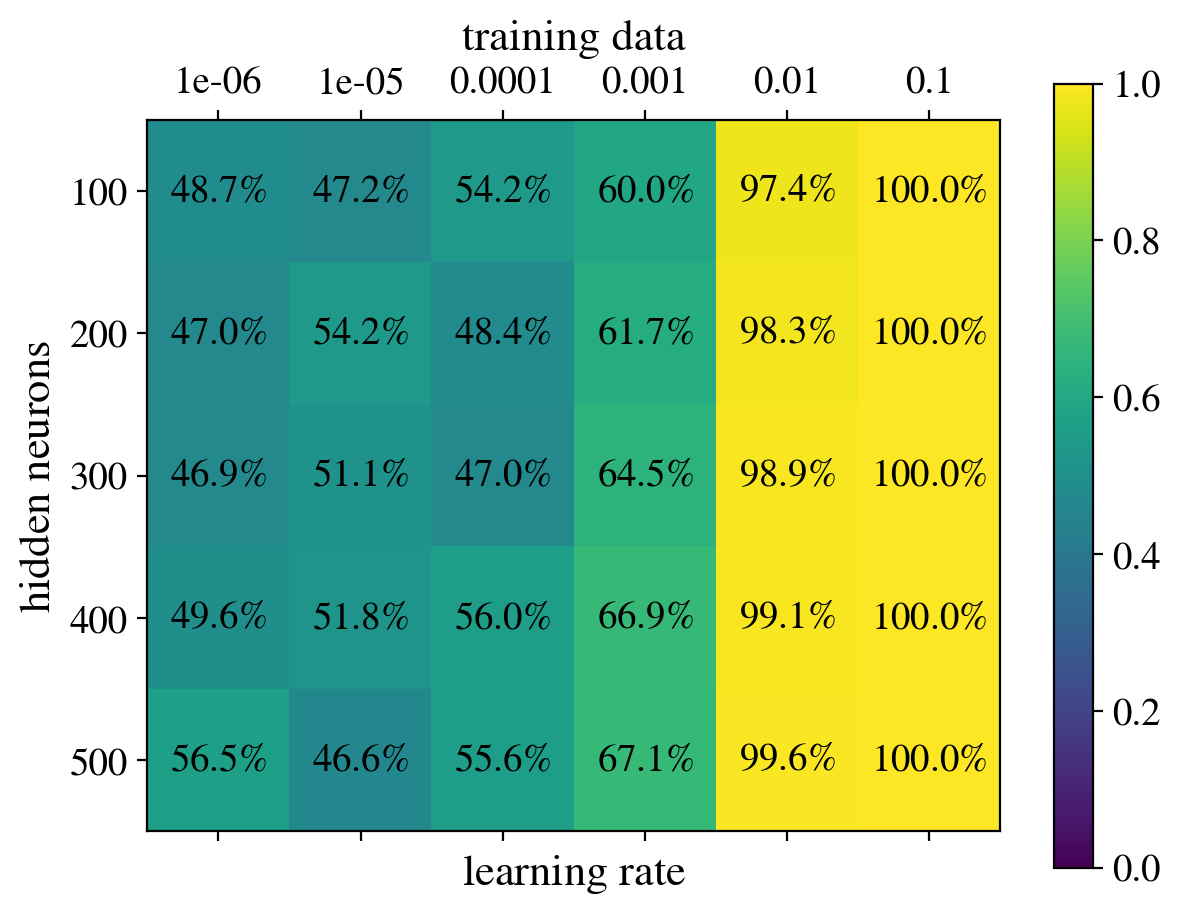

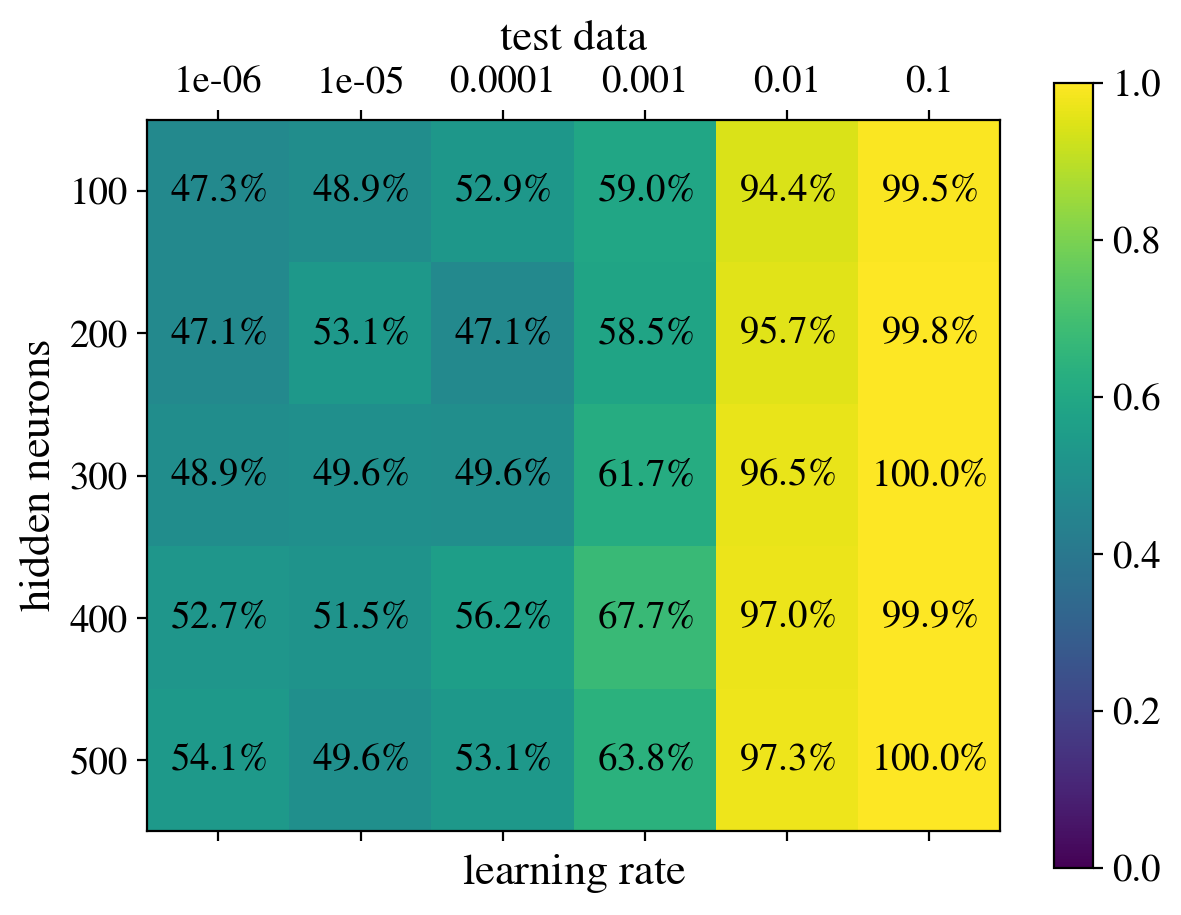

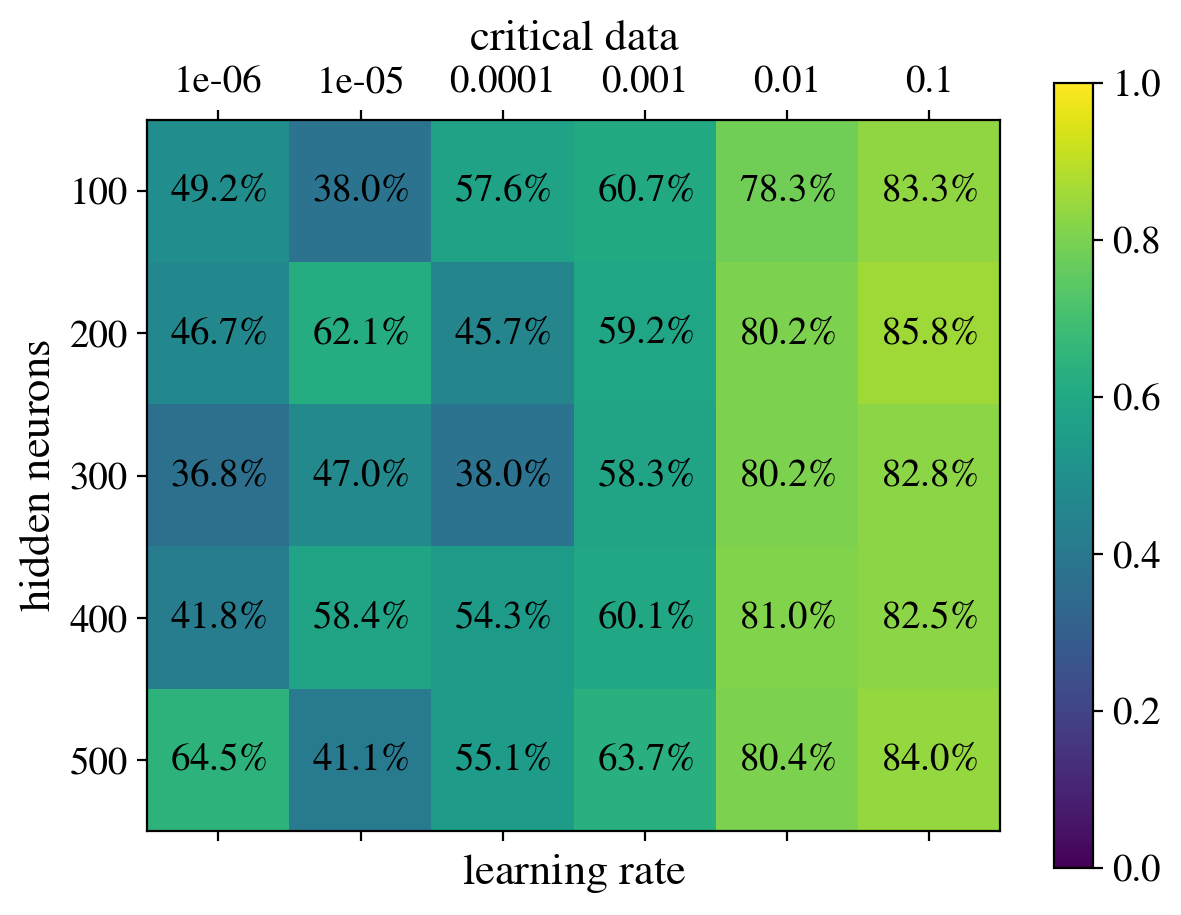

In [21]:
grid_search()

<span style="color:blue"> <i> 1. Do the grid search over 5 different types of activation functions (https://www.tensorflow.org/api_guides/python/nn#Activation_Functions). Evaluate the performance for each case and determine which gives the best accuracy. You can assume an arbitrary DNN. Show results for training, test, and critical data. </i></span> <br>

In [22]:
def create_DNN(activator,n_hidden1=100, n_hidden2=100, learning_rate=1e-6):
    with tf.name_scope('data'):
        X=tf.placeholder(tf.float32, shape=(None,n_feats))
        Y=tf.placeholder(tf.float32, shape=(None,n_categories))
        dropout_keepprob=tf.placeholder(tf.float32)

    with tf.name_scope("dnn"):
        hidden1 = tf.layers.dense(X, n_hidden1, activation = activator)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activator)
        logits = tf.layers.dense(hidden2, n_outputs)

    with tf.name_scope('loss'):
        xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = logits)
        loss = tf.reduce_mean(xentropy)

    with tf.name_scope('optimiser'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float64) # change data type
    #     correct_prediction = tf.nn.in_top_k(logits, Y, 1)
        accuracy = tf.reduce_mean(correct_prediction)

    return X, Y, dropout_keepprob, loss, optimizer, accuracy

def evaluate_model(neurons,lr,activator):

    training_epochs=100
    batch_size=100


    X, Y, dropout_keepprob, loss, optimizer, accuracy = create_DNN(activator,n_hidden1=neurons, n_hidden2=neurons, learning_rate=lr)
    with tf.Session() as sess:

        # initialize the necessary variables, in this case, w and b
        sess.run(tf.global_variables_initializer())

        # train the DNN
        for epoch in range(training_epochs):

            batch_X, batch_Y = Dataset.train.next_batch(batch_size)

            sess.run(optimizer, feed_dict={X: batch_X,Y: batch_Y,dropout_keepprob: 0.5})


        # test DNN performance on entire train test and critical data sets
        train_loss, train_accuracy = sess.run([loss, accuracy],
                                                    feed_dict={X: Dataset.train.data_X,
                                                               Y: Dataset.train.data_Y,
                                                               dropout_keepprob: 0.5}
                                                                )
        print("train loss/accuracy:", train_loss, train_accuracy)

        test_loss, test_accuracy = sess.run([loss, accuracy],
                                                    feed_dict={X: Dataset.test.data_X,
                                                               Y: Dataset.test.data_Y,
                                                               dropout_keepprob: 1.0}
                                                               )

        print("test loss/accuracy:", test_loss, test_accuracy)

        critical_loss, critical_accuracy = sess.run([loss, accuracy],
                                                    feed_dict={X: Dataset.critical.data_X,
                                                               Y: Dataset.critical.data_Y,
                                                               dropout_keepprob: 1.0}
                                                               )
        print("crtitical loss/accuracy:", critical_loss, critical_accuracy)

    return train_loss,train_accuracy,test_loss,test_accuracy,critical_loss,critical_accuracy

def new_grid_search():
    """This function performs a grid search over a set of different learning rates
    and a number of hidden layer neurons."""

    # perform grid search over activators
    neurons=200
    lr = 1e-2
    activators=[tf.nn.relu, tf.nn.tanh, tf.nn.sigmoid, tf.nn.swish, tf.nn.selu]
    names = ['relu', 'tanh', 'sigmoid', 'swish', 'selu']

    # pre-alocate variables to store accuracy and loss data
    train_loss=np.zeros(len(names),dtype=np.float64)
    train_accuracy=np.zeros_like(train_loss)
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)
    critical_loss=np.zeros_like(train_loss)
    critical_accuracy=np.zeros_like(train_loss)

    # do grid search
    for i in range(len(names)):
      print("training DNN with " + names[i])
      activator = activators[i]
      train_loss[i],train_accuracy[i],\
      test_loss[i],test_accuracy[i],\
      critical_loss[i],critical_accuracy[i] = evaluate_model(neurons,lr, activator)

    return train_accuracy, test_accuracy, critical_accuracy

In [23]:
train_accuracy, test_accuracy, critical_accuracy = new_grid_search()


training DNN with relu
train loss/accuracy: 0.2266668 0.9772435897435897
test loss/accuracy: 0.268902 0.9447115384615384
crtitical loss/accuracy: 0.45699057 0.8083333333333333
training DNN with tanh
train loss/accuracy: 0.6451872 0.653525641025641
test loss/accuracy: 0.7469343 0.5413461538461538
crtitical loss/accuracy: 0.78042364 0.5141666666666667
training DNN with sigmoid
train loss/accuracy: 0.68965566 0.5365384615384615
test loss/accuracy: 0.69040066 0.5235576923076923
crtitical loss/accuracy: 0.67869514 0.6
training DNN with swish
train loss/accuracy: 0.25071394 0.9634615384615385
test loss/accuracy: 0.2955162 0.9293269230769231
crtitical loss/accuracy: 0.44558084 0.825
training DNN with selu
train loss/accuracy: 0.251226 0.9368589743589744
test loss/accuracy: 0.37617844 0.8576923076923076
crtitical loss/accuracy: 0.5279078 0.7583333333333333


In [24]:
names = ['relu', 'tanh', 'sigmoid', 'swish', 'selu']
for i, (act, train_acc, test_acc, crit_acc) in enumerate(zip(names, train_accuracy, test_accuracy, critical_accuracy)):
    print(f'Results for {act} activation function:')
    print(f'\t Train Accuracy: {train_acc} - Test Accuracy: {test_acc} - Critical Accuracy: {crit_acc}\n')


Results for relu activation function:
	 Train Accuracy: 0.9772435897435897 - Test Accuracy: 0.9447115384615384 - Critical Accuracy: 0.8083333333333333

Results for tanh activation function:
	 Train Accuracy: 0.653525641025641 - Test Accuracy: 0.5413461538461538 - Critical Accuracy: 0.5141666666666667

Results for sigmoid activation function:
	 Train Accuracy: 0.5365384615384615 - Test Accuracy: 0.5235576923076923 - Critical Accuracy: 0.6

Results for swish activation function:
	 Train Accuracy: 0.9634615384615385 - Test Accuracy: 0.9293269230769231 - Critical Accuracy: 0.825

Results for selu activation function:
	 Train Accuracy: 0.9368589743589744 - Test Accuracy: 0.8576923076923076 - Critical Accuracy: 0.7583333333333333



<span style="color:blue"> <i> 2. Do the grid search over 5 different numbers of epochs and batch sizes. Make a 2D heat map as shown in the example. You can assume an arbitrary DNN. Show results for training, test, and critical data.  </i></span> <br>

In [25]:
def create_DNN(n_hidden1=100, n_hidden2=100, learning_rate=1e-6):
    with tf.name_scope('data'):
        X=tf.placeholder(tf.float32, shape=(None,n_feats))
        Y=tf.placeholder(tf.float32, shape=(None,n_categories))
        dropout_keepprob=tf.placeholder(tf.float32)

    with tf.name_scope("dnn"):
        hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu)
        logits = tf.layers.dense(hidden2, n_outputs)

    with tf.name_scope('loss'):
        xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = logits)
        loss = tf.reduce_mean(xentropy)

    with tf.name_scope('optimiser'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float64) # change data type
    #     correct_prediction = tf.nn.in_top_k(logits, Y, 1)
        accuracy = tf.reduce_mean(correct_prediction)

    return X, Y, dropout_keepprob, loss, optimizer, accuracy



def evaluate_model(training_epochs, batch_size,neurons,lr):


    X, Y, dropout_keepprob, loss, optimizer, accuracy = create_DNN(n_hidden1=neurons, n_hidden2=neurons, learning_rate=lr)
    with tf.Session() as sess:

        # initialize the necessary variables, in this case, w and b
        sess.run(tf.global_variables_initializer())

        # train the DNN
        for epoch in range(training_epochs):

            batch_X, batch_Y = Dataset.train.next_batch(batch_size)

            sess.run(optimizer, feed_dict={X: batch_X,Y: batch_Y,dropout_keepprob: 0.5})


        # test DNN performance on entire train test and critical data sets
        train_loss, train_accuracy = sess.run([loss, accuracy],
                                                    feed_dict={X: Dataset.train.data_X,
                                                               Y: Dataset.train.data_Y,
                                                               dropout_keepprob: 0.5}
                                                                )
        print("train loss/accuracy:", train_loss, train_accuracy)

        test_loss, test_accuracy = sess.run([loss, accuracy],
                                                    feed_dict={X: Dataset.test.data_X,
                                                               Y: Dataset.test.data_Y,
                                                               dropout_keepprob: 1.0}
                                                               )

        print("test loss/accuracy:", test_loss, test_accuracy)

        critical_loss, critical_accuracy = sess.run([loss, accuracy],
                                                    feed_dict={X: Dataset.critical.data_X,
                                                               Y: Dataset.critical.data_Y,
                                                               dropout_keepprob: 1.0}
                                                               )
        print("crtitical loss/accuracy:", critical_loss, critical_accuracy)

    return train_loss,train_accuracy,test_loss,test_accuracy,critical_loss,critical_accuracy

def newer_grid_search():
    """This function performs a grid search over a set of different learning rates
    and a number of hidden layer neurons."""

    # perform grid search over learnign rate and number of hidden neurons
    epochs=[1, 5, 10, 50, 100]
    batches=[10, 50, 100, 200, 300]
    neurons=200
    lr = 1e-2

    # pre-alocate variables to store accuracy and loss data
    train_loss=np.zeros((len(epochs),len(batches)),dtype=np.float64)
    train_accuracy=np.zeros_like(train_loss)
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)
    critical_loss=np.zeros_like(train_loss)
    critical_accuracy=np.zeros_like(train_loss)

    # do grid search
    for i, epoch in enumerate(epochs):
        for j, batch in enumerate(batches):

            print("training DNN with %4d training_epochs and SGD batch_size=%0.6f." %(epoch,batch) )

            train_loss[i,j],train_accuracy[i,j],\
            test_loss[i,j],test_accuracy[i,j],\
            critical_loss[i,j],critical_accuracy[i,j] = evaluate_model(epoch,batch,neurons,lr)

    return train_accuracy, test_accuracy, critical_accuracy

In [26]:
train_accuracy_3, test_accuracy_3, critical_accuracy_3 = newer_grid_search()


training DNN with    1 training_epochs and SGD batch_size=10.000000.
train loss/accuracy: 0.76731867 0.5160256410256411
test loss/accuracy: 0.74295783 0.5302884615384615
crtitical loss/accuracy: 0.7662913 0.5208333333333334
training DNN with    1 training_epochs and SGD batch_size=50.000000.
train loss/accuracy: 0.7465962 0.5641025641025641
test loss/accuracy: 0.77502584 0.5447115384615384
crtitical loss/accuracy: 0.7017458 0.6066666666666667
training DNN with    1 training_epochs and SGD batch_size=100.000000.
train loss/accuracy: 0.85011643 0.5509615384615385
test loss/accuracy: 0.87232876 0.541826923076923
crtitical loss/accuracy: 0.73553437 0.6441666666666667
training DNN with    1 training_epochs and SGD batch_size=200.000000.
train loss/accuracy: 0.80345356 0.496474358974359
test loss/accuracy: 0.8088306 0.49423076923076925
crtitical loss/accuracy: 0.8088933 0.49916666666666665
training DNN with    1 training_epochs and SGD batch_size=300.000000.
train loss/accuracy: 0.97293794 0

In [27]:
epochs=[1, 5, 10, 50, 100]
batches=[10, 50, 100, 200, 300]

def plot_data(x,y,data, title):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', cmap = 'magma',vmin=0, vmax=1)
    fig.colorbar(cax)

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{training\\ epochs}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{batch\\ sizes}$',fontsize=fontsize)

    ax.set_title(title,fontsize=fontsize)

    plt.tight_layout()

    plt.show()

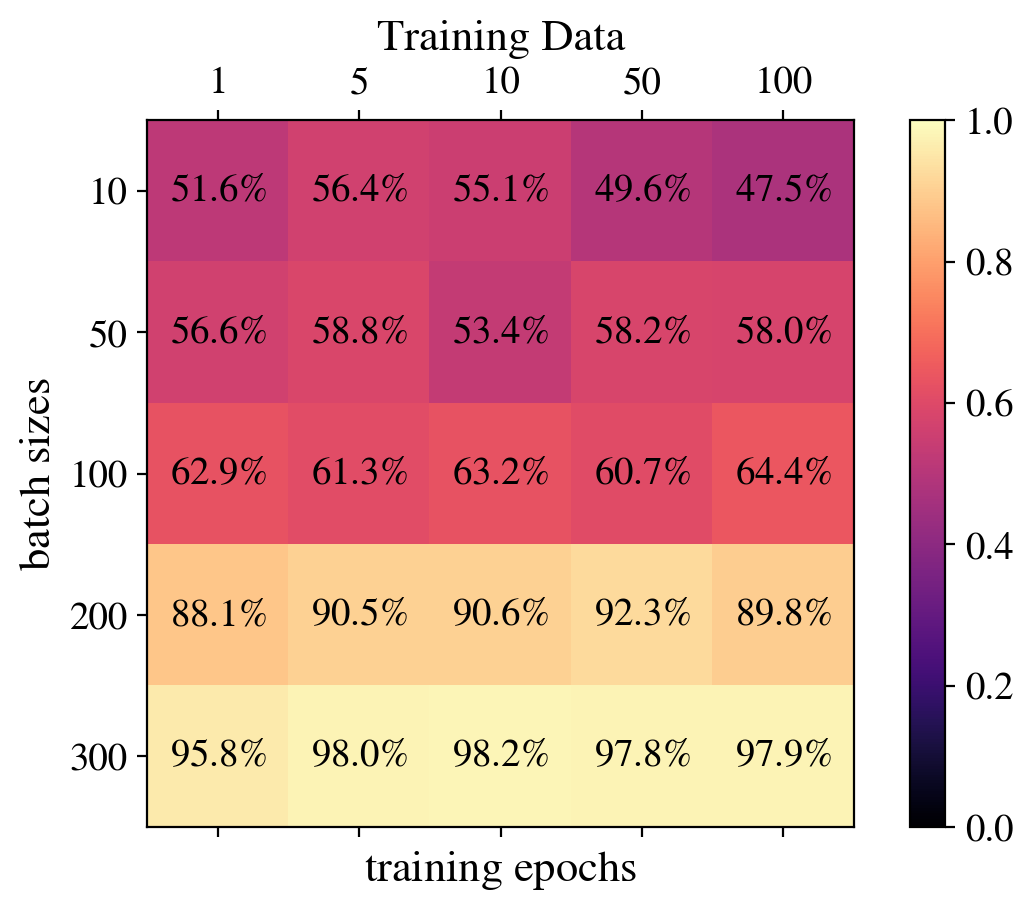

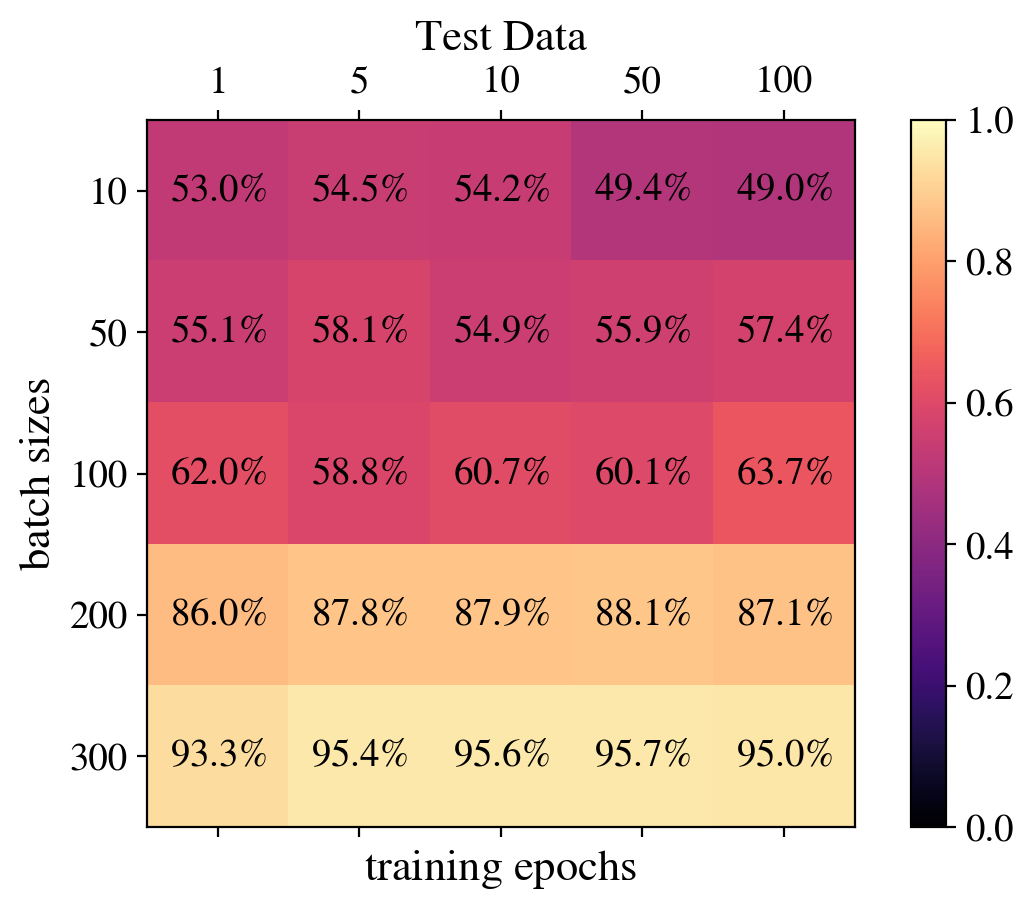

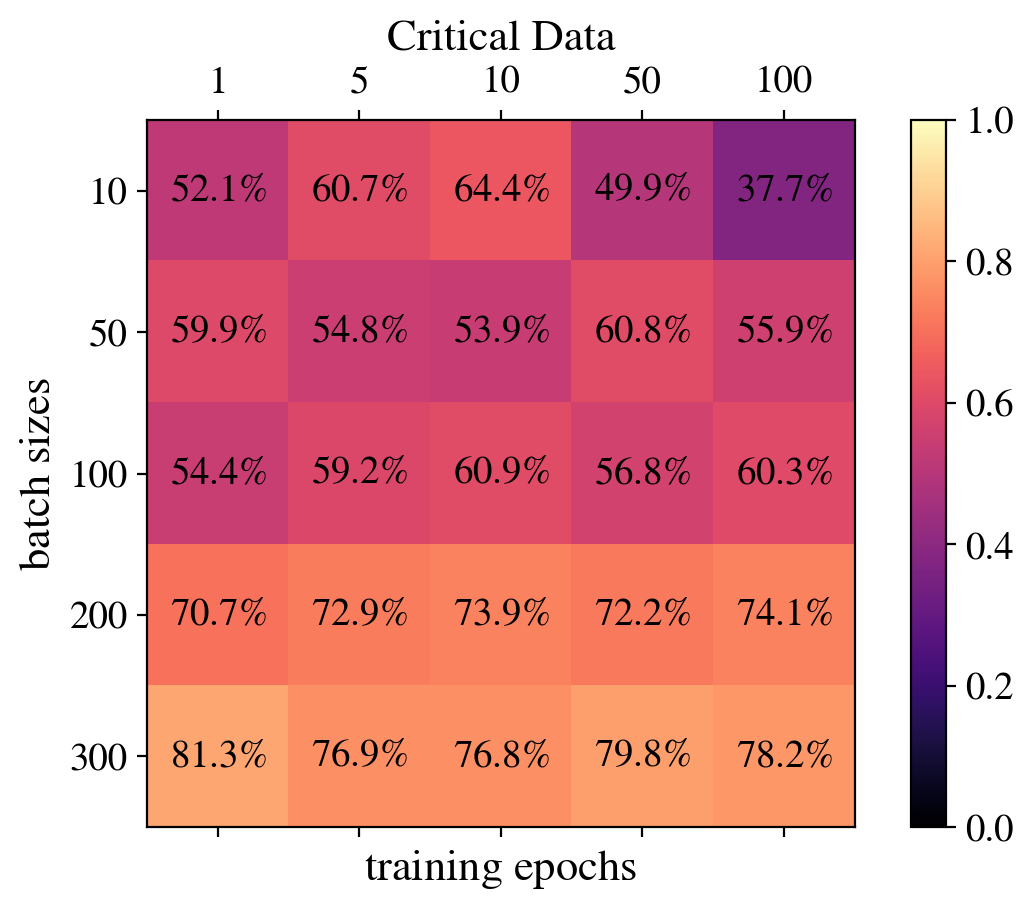

In [28]:
plot_data(epochs,batches,train_accuracy_3, "Training Data")
plot_data(epochs,batches,test_accuracy_3, "Test Data")
plot_data(epochs,batches,critical_accuracy_3, "Critical Data")

In [30]:
!jupyter nbconvert --to html "/content/drive/MyDrive/P188_288/P188_288_Project3/Project3_188_Q2.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/P188_288/P188_288_Project3/Project3_188_Q2.ipynb to html
[NbConvertApp] Writing 1788648 bytes to /content/drive/MyDrive/P188_288/P188_288_Project3/Project3_188_Q2.html
